## Import Modules

In [34]:
import requests
import json
from io import StringIO
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import zipfile

# Install these!
import descartes
import geopandas
import contextily as ctx
import fiona
import shapely

In [2]:
tree_df_path = "../../docs/results/latest/mugration/mugration.tsv"
outdir = "../../docs/results/latest/geo"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### Variables

In [39]:
NO_DATA_CHAR = "NA"
GEO_ATTR = "Province"
CRS="epsg:4326"
WEB_MERCATOR_CRS = "epsg:3857"

### Geo Config

In [4]:
# Order: bottom-left, bottom-right, top-right, top-left (sw, se, ne, nw)

region_poly = {
    "Caucasus" : {"wsen": [35.0000, 30.0009, 60.0000, 50.0000]},
    #Caucasus" : {"wsen": [40.058841, 40.202162, -75.042164, -74.924594]},
    "Europe" : {"wsen" : [-10, 30, 35, 70]},
    "Asia" : {"wsen" : [60, 0, 140, 70]},
}

df_columns = ["Region","Lon", "Lat"]
region_df = pd.DataFrame(columns=df_columns)

for region in region_poly:
    wsen = region_poly[region]["wsen"]
    
    # add to dataframe
    df = pd.DataFrame([
         [region, wsen[0], wsen[1]],
         [region, wsen[2], wsen[1]],
         [region, wsen[2], wsen[3]],
         [region, wsen[0], wsen[3]],
         ],
         columns=df_columns
    )
    region_df = region_df.append(df, ignore_index = True)
    
    # Polygon should be: sw, se, ne, nw
    region_poly[region]["poly"] = shapely.geometry.Polygon([
        (wsen[0], wsen[1]), 
        (wsen[2], wsen[1]), 
        (wsen[2], wsen[3]), 
        (wsen[0], wsen[3]),
    ])
    region_poly[region]["geoseries"] = geopandas.GeoSeries(region_poly[region]["poly"])
    region_poly[region]["geoseries"].crs = CRS
    region_poly[region]["xlim"] = (wsen[0], wsen[2])
    region_poly[region]["ylim"] = (wsen[1], wsen[3])

region_gdf = geopandas.GeoDataFrame(
    region_df, 
    geometry=geopandas.points_from_xy(region_df.Lon, region_df.Lat))
region_gdf.set_crs(CRS, inplace=True)

,Region,Lon,Lat,geometry
0,Caucasus,35.0,30.0009,POINT (35.00000 30.00090)
1,Caucasus,60.0,30.0009,POINT (60.00000 30.00090)
2,Caucasus,60.0,50.0000,POINT (60.00000 50.00000)
3,Caucasus,35.0,50.0000,POINT (35.00000 50.00000)
4,Europe,-10.0,30.0000,POINT (-10.00000 30.00000)
5,Europe,35.0,30.0000,POINT (35.00000 30.00000)
6,Europe,35.0,70.0000,POINT (35.00000 70.00000)
7,Europe,-10.0,70.0000,POINT (-10.00000 70.00000)
8,Asia,60.0,0.0000,POINT (60.00000 0.00000)
9,Asia,140.0,0.0000,POINT (140.00000 0.00000)


In [5]:
region_gdf.to_crs(epsg=3857)

,Region,Lon,Lat,geometry
0,Caucasus,35.0,30.0009,POINT (3896182.178 3503665.531)
1,Caucasus,60.0,30.0009,POINT (6679169.448 3503665.531)
2,Caucasus,60.0,50.0000,POINT (6679169.448 6446275.841)
3,Caucasus,35.0,50.0000,POINT (3896182.178 6446275.841)
4,Europe,-10.0,30.0000,POINT (-1113194.908 3503549.844)
5,Europe,35.0,30.0000,POINT (3896182.178 3503549.844)
6,Europe,35.0,70.0000,POINT (3896182.178 11068715.659)
7,Europe,-10.0,70.0000,POINT (-1113194.908 11068715.659)
8,Asia,60.0,0.0000,POINT (6679169.448 0.000)
9,Asia,140.0,0.0000,POINT (15584728.711 0.000)


### Global Plot Config

In [40]:
dpi=400

DEF_COL_LIST = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Font
SM_FONT = 5
MED_FONT = 8
LG_FONT = 10

plt.rc('font', size=SM_FONT)          # controls default text sizes
plt.rc('figure', titlesize=LG_FONT)  # fontsize of the figure title
#plt.rc('axes', labelsize=MED_FONT)    # fontsize of the x and y labels

CMAP="tab10"

cmap = matplotlib.cm.get_cmap(CMAP)
cmaplist = [cmap(i) for i in range(cmap.N)]
print(cmaplist)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)]


### Contextily Basemaps

In [7]:
# Change the geoseries crs
region_gdf.to_crs(epsg=3857, inplace=True)

0    POINT (3896182.178 3503665.531)
1    POINT (6679169.448 3503665.531)
2    POINT (6679169.448 6446275.841)
3    POINT (3896182.178 6446275.841)
Name: geometry, dtype: geometry
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


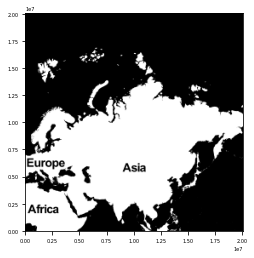

In [8]:
w = 3896182.178
s = 3503665.531
n = 6679169.448
e = 6446275.841

print(region_df[region_df["Region"] == "Caucasus"].geometry)

ctx_img, ctx_ext = ctx.bounds2img(
     w,
     s,
     e,
     n,
     ll=True,
     source=ctx.providers.Stamen.Toner,
     zoom=1,
     #crs=CRS,
    )
print(ctx_img)
plt.imshow(ctx_img, extent=ctx_ext)
# Reset the geoseries crs

'out_path = os.path.join(outdir, "liverpool.tif")  \n_ = ctx.bounds2raster(w, s, e, n,\n                     ll=True,\n                     path=out_path,\n                     source=ctx.providers.CartoDB.Positron\n                    )'

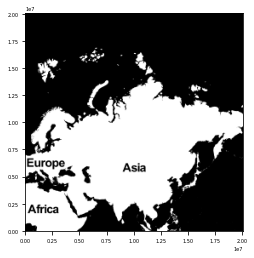

In [9]:
"""w, s, e, n = (-3.0816650390625,
              53.268087670237485,
             -2.7582550048828125,
              53.486002749115556)"""

w, s, e, n = (35,
              30,
             60,
              50)
ctx_img, ctx_ext = ctx.bounds2img(w,
                                     s,
                                     e,
                                     n,
                                     ll=True,
                                     source=ctx.providers.Stamen.Toner,
                                     zoom=1,
                                     #crs=CRS,
                                    )

plt.imshow(ctx_img, extent=ctx_ext)
"""out_path = os.path.join(outdir, "liverpool.tif")  
_ = ctx.bounds2raster(w, s, e, n,
                     ll=True,
                     path=out_path,
                     source=ctx.providers.CartoDB.Positron
                    )"""

---
## Import Dataframe

Read in as pandas dataframe

In [10]:
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

Convert to geopandas dataframe

In [11]:
# Remove NO DATA Cells
# RETHINK THIS WHEN INTERNAL NODES HAVE DATA!!
df = tree_df[tree_df[GEO_ATTR + "Lon"] != NO_DATA_CHAR]
geometry = [shapely.geometry.Point(xy) for xy in zip(df[GEO_ATTR + "Lon"], df[GEO_ATTR + "Lat"])]
df = df.drop([GEO_ATTR + "Lon", GEO_ATTR + "Lat"], axis=1)
#WGS84 = "epsg:4326"
gdf_points = geopandas.GeoDataFrame(df, crs=CRS, geometry=geometry)

## Import reference datasets

Import the world dataset from geopandas

In [12]:
gdf_points_count = {}

for geo in gdf_points[GEO_ATTR]:
    if geo not in gdf_points_count:
        gdf_points_count[geo] = 0
    gdf_points_count[geo] += 1

gdf_points_size = []

for geo in gdf_points[GEO_ATTR]:
    gdf_points_size.append(gdf_points_count[geo])

## Global

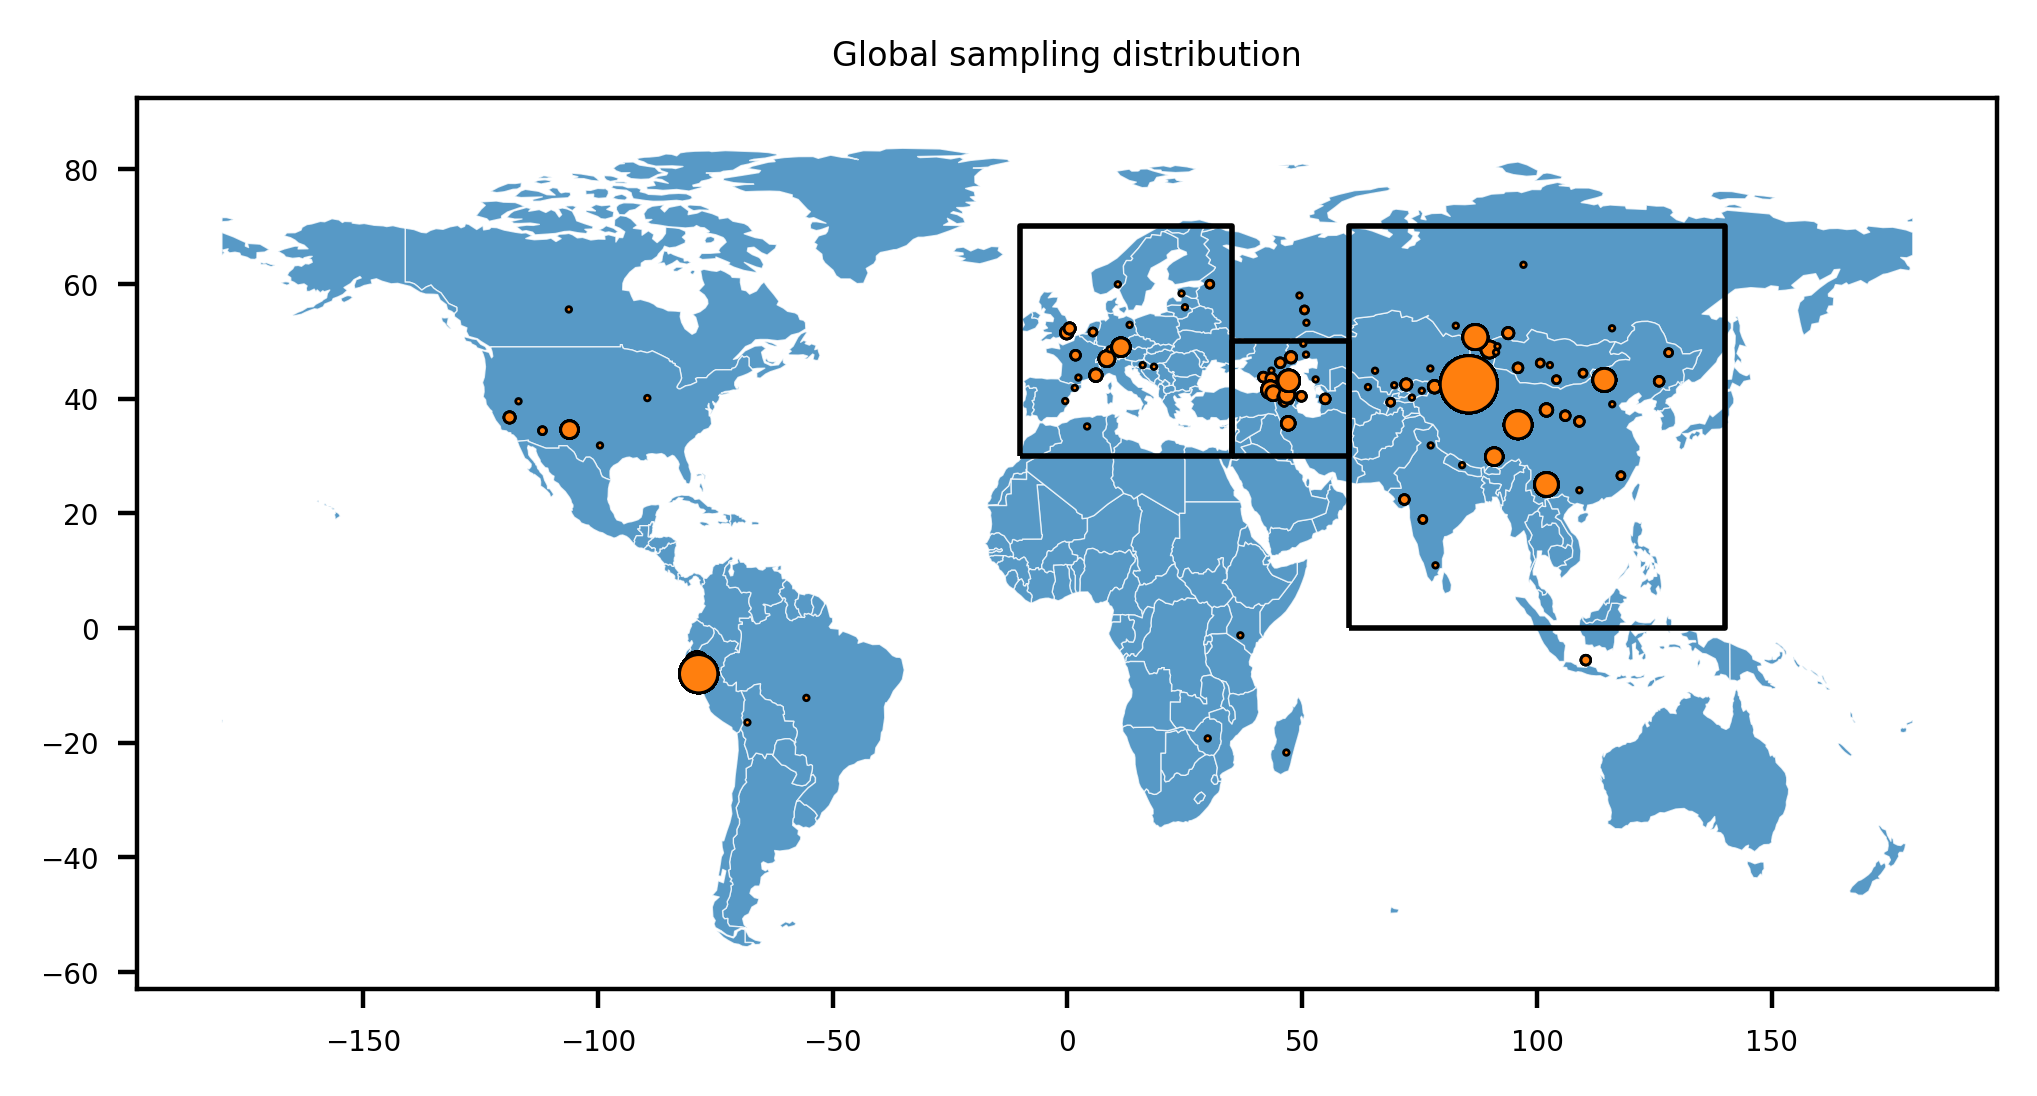

In [13]:
world_polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax1 = plt.subplots(1, dpi=dpi)

# Basemap
world_polygons.plot(ax=ax1, 
                    zorder=1, 
                    alpha=0.75, 
                    color=DEF_COL_LIST[0],
                    edgecolor="white", 
                    linewidth=0.25)

# Points
gdf_points.plot(ax=ax1, 
                zorder=2, 
                markersize=gdf_points_size, 
                color=DEF_COL_LIST[1],
                edgecolor="black",
                linewidths=0.5,
                )

# Polygons
for region in region_poly:
    region_poly[region]["geoseries"].plot(color="none", edgecolor="black", ax=ax1)
#caucasus_geoseries.plot(color="none", edgecolor="black", ax=ax1)
#europe_geoseries.plot(color="none", edgecolor="black", ax=ax1)
#asia_geoseries.plot(color="none", edgecolor="black", ax=ax1)

ax1.set_ylim(-63,)
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
ax1.set_title("Global sampling distribution")

#plt.axis('off')

# Save
out_path = os.path.join(outdir, "world_sample_distribution.jpg") 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

## Caucasus

(35.0, 60.0, 30.0009, 50.0)

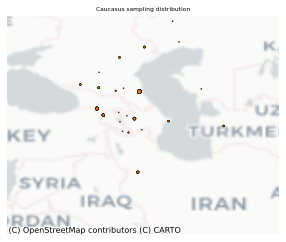

In [17]:
region_xlim = (35, 60)
region_ylim = [30, 50]

"""fig, ax1 = plt.subplots(1, 
                        dpi=dpi
                       )"""

ax1 = gdf_points.plot( 
                markersize=gdf_points_size, 
                color=DEF_COL_LIST[1],
                edgecolor="black",
                linewidths=0.5,
                )

ctx.add_basemap(
    ax1, 
    crs=gdf_points.crs.to_string(),
    #source=ctx.providers.Stamen.TonerLite,
    source=ctx.providers.CartoDB.Positron,
    zoom=3,
)

ax1.set_xlim(region_poly["Caucasus"]["xlim"])
ax1.set_ylim(region_poly["Caucasus"]["ylim"])
ax1.set_title("Caucasus sampling distribution")
plt.axis('off')

Text(0.5, 1.0, 'Caucasus sampling distribution')

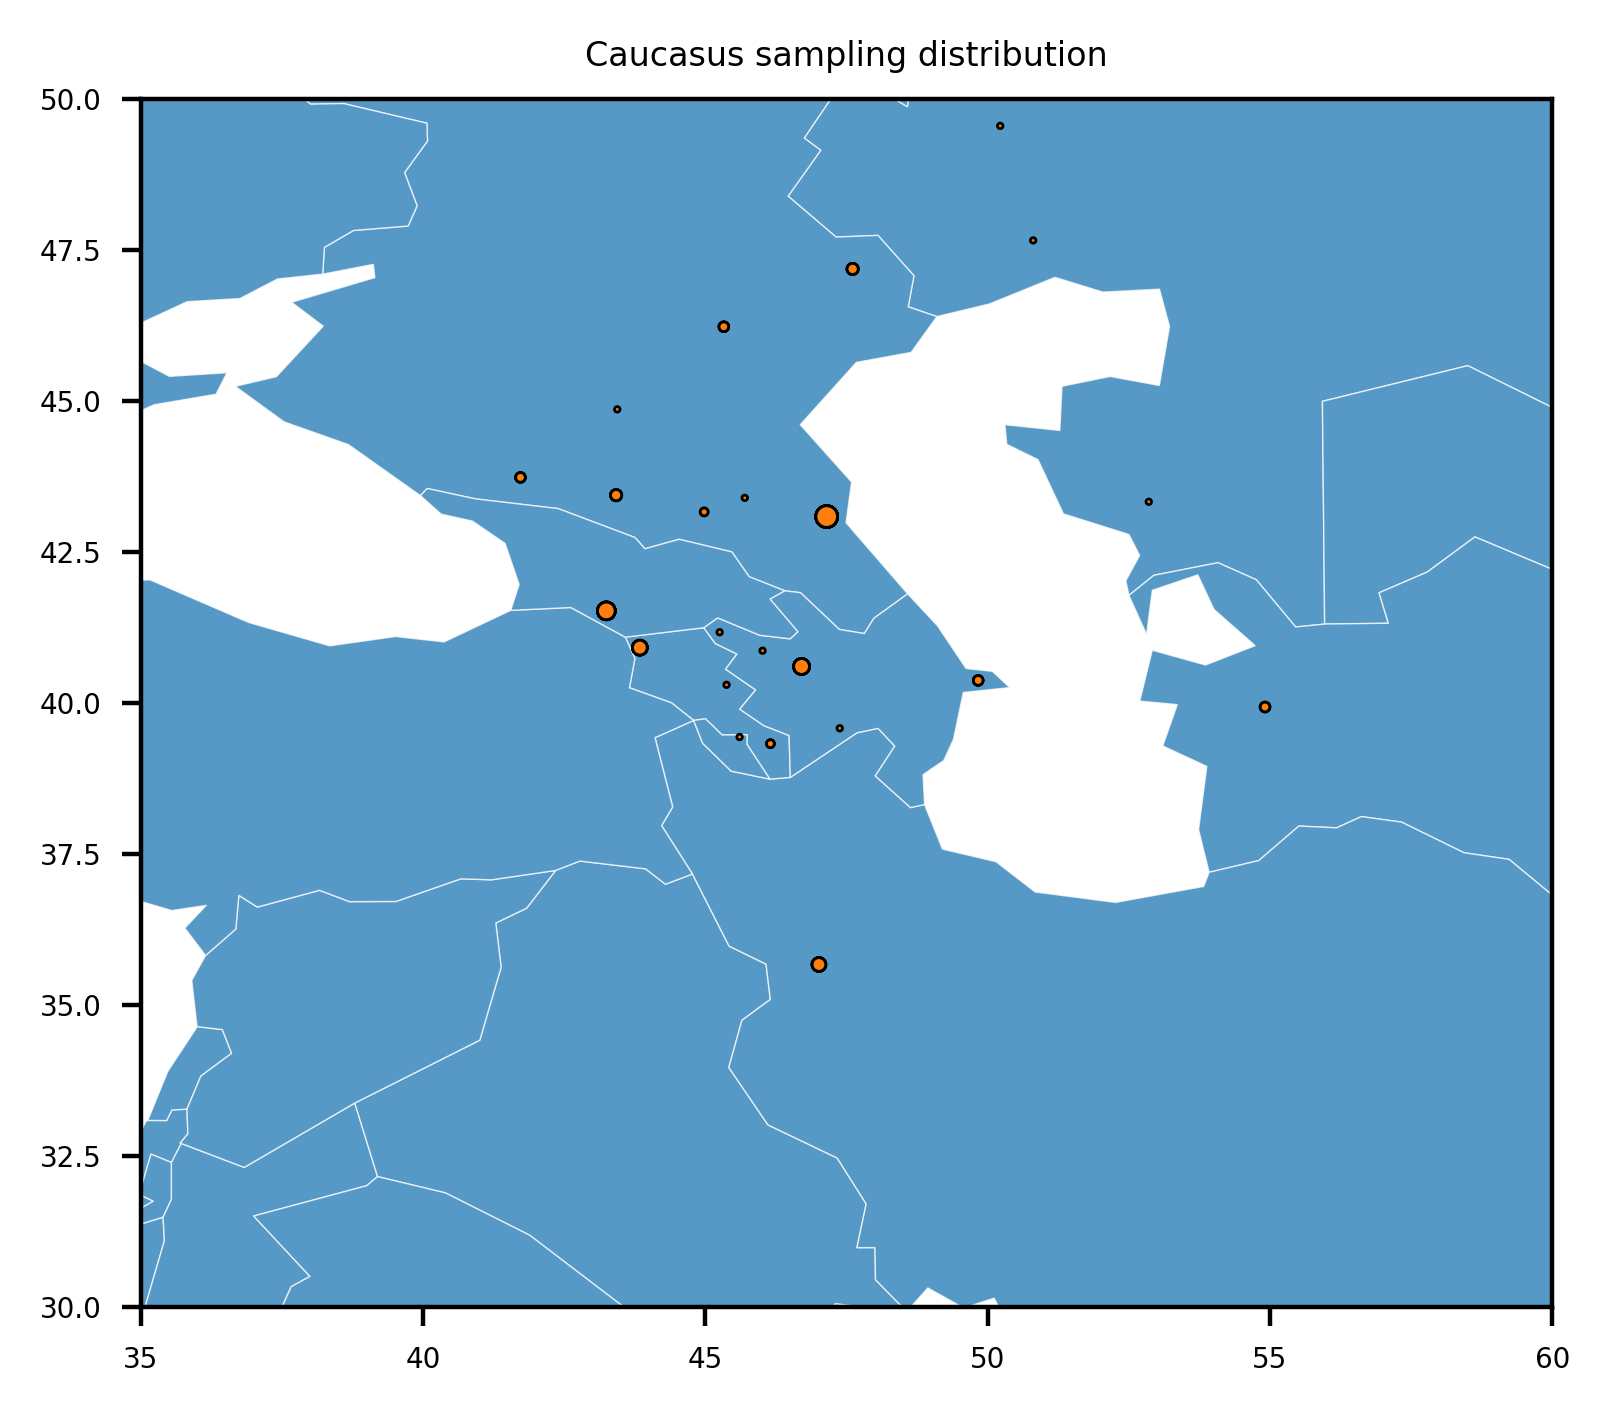

In [18]:
region_xlim = (35, 60)
region_ylim = [30, 50]

fig, ax1 = plt.subplots(1, 
                        dpi=dpi
                       )

# Size the points
gdf_points_count = {}
gdf_points[GEO_ATTR]

world_polygons.plot(ax=ax1, 
                    zorder=1, 
                    alpha=0.75, 
                    color=DEF_COL_LIST[0],
                    edgecolor="white", 
                    linewidth=0.25)
gdf_points.plot(ax=ax1, 
                zorder=2, 
                markersize=gdf_points_size, 
                color=DEF_COL_LIST[1],
                edgecolor="black",
                linewidths=0.5,
                )

ax1.set_xlim(region_xlim)
ax1.set_ylim(region_ylim)
ax1.set_title("Caucasus sampling distribution")
#plt.axis('off')


In [ ]:
"""db = gdf_points[gdf_points["Country"] == "Armenia"]
ax = gdf_points.plot(color="red", figsize=(9, 9))
ctx.add_basemap(
    ax, 
    crs=db.crs.to_string(),
    source=ctx.providers.Stamen.TerrainBackground,
)"""

### Europe

---
## OLD

### GADM Country Datasets

/workspace/.pip-modules/lib/python3.7/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/workspace/.pip-modules/lib/python3.7/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/workspace/.pip-modules/lib/python3.7/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


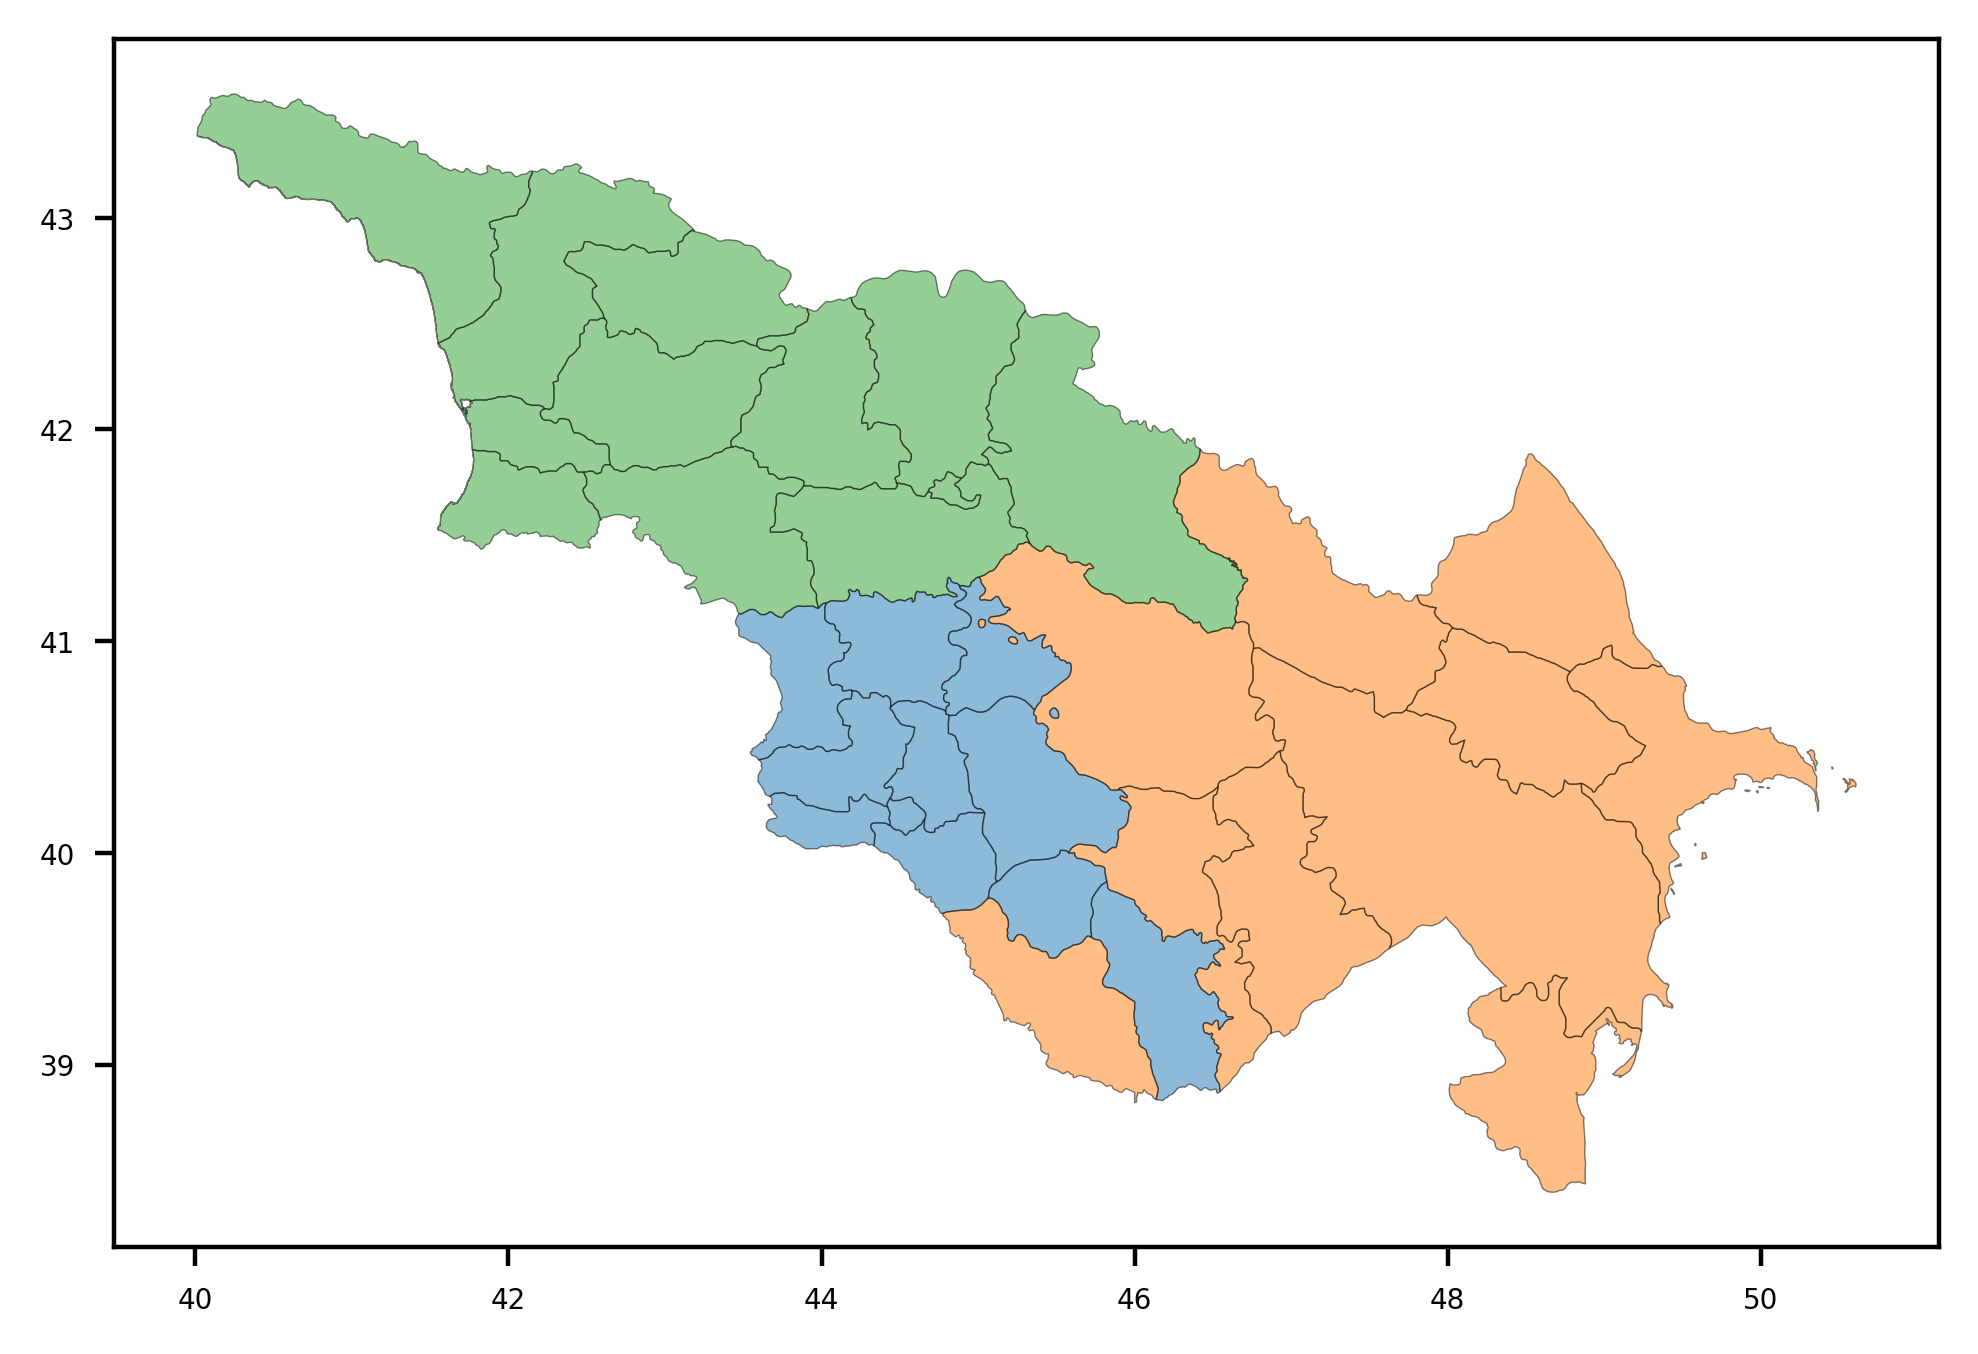

In [44]:
country_codes = ["ARM", "AZE", "GEO"]

country_codes

fig, ax1 = plt.subplots(1, dpi=dpi)

for code in country_codes:
    zip_file_url = "https://biogeo.ucdavis.edu/data/gadm3.6/gpkg/gadm36_{}_gpkg.zip".format(code)    
    zip_filename = os.path.basename(zip_file_url)
    gpkg_filename = zip_filename.replace("_gpkg.zip", ".gpkg")
    gpkg_path = os.path.join(outdir, gpkg_filename)
    target_layer = os.path.splitext(gpkg_filename)[0] + "_1"
    chunk_size = 128
    result = requests.get(zip_file_url, stream=True)
    out_path = os.path.join(outdir, os.path.basename(zip_file_url)) 

    with open(out_path, 'wb') as fd:
        for chunk in result.iter_content(chunk_size=chunk_size):
            fd.write(chunk)


    with zipfile.ZipFile(out_path, 'r') as zipObj:
        zipObj.extract(gpkg_filename, path=outdir)

    for layername in fiona.listlayers(gpkg_path):
        if layername ==  target_layer:
            geopkg = geopandas.read_file(gpkg_path, layer=layername)
            geopkg.plot(ax=ax1, 
                        zorder=1, 
                        alpha=0.50, 
                        color=cmaplist[country_codes.index(code)],
                        edgecolor="black", 
                        linewidth=0.25,
                        )


In [48]:
rus_gdf = geopandas.read_file(os.path.join(outdir, "gadm36_RUS.gpkg"))
for name in rus_gdf.NAME_2: print(name)

/workspace/.pip-modules/lib/python3.7/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Giaginskiy rayon
Koshekhabl'skiy rayon
Krasnogvardeyskiy rayon
Maykop
Maykopskiy rayon
Shovgenovskiy rayon
Takhtamukaysk rayon
Teuchezhskiy rayon
Aleysk
Aleyskiy rayon
Altayskiy rayon
Baevskiy rayon
Barnaul gorsovet
Belokurikha
Biysk
Biyskiy rayon
Blagoveshchenskiy rayon
Burlinskiy rayon
Bystroistokskiy rayon
Charyshskiy rayon
Egor'evskiy rayon
El'tsovskiy rayon
Kalmanskiy rayon
Kamenskiy rayon
Khabarskiy rayon
Klyuchevskiy rayon
Kosikhinskiy rayon
Krasnogorskiy rayon
Krasnoshchekovskiy rayon
Krutikhinskiy rayon
Kulundinskiy rayon
Kur'inskiy rayon
Kytmanovskiy rayon
Loktevskiy rayon
Mamontovskiy rayon
Mikhaylovskiy rayon
Nemetskiy Natsional'nyy rayon
Novoaltaysk
Novochikhinskiy rayon
Pankrushikhinskiy rayon
Pavlovskiy rayon
Pervomayskiy rayon
Petropavlovskiy rayon
Pospelikhinskiy rayon
Rebrikhinskiy rayon
Rodinskiy rayon
Romanovskiy rayon
Rubtsovsk
Rubtsovskiy rayon
Shelabolikhinskiy rayon
Shipunovskiy rayon
Slavgorod
Slavgorodskiy rayon
Smolenskiy rayon
Soloneshenskiy rayon
Soltonskiy

Sarapul'skiy rayon
Seltinskiy rayon
Sharkanskiy rayon
Syumsinskiy rayon
Uvinskiy rayon
Vavozhskiy rayon
Votkinsk
Votkinskiy rayon
Yakshur-Bod'inskiy rayon
Yarskiy rayon
Yukamenskiy rayon
Zav'yalovskiy rayon
Barysh
Baryshskiy rayon
Bazarnosyzganskiy rayon
Cherdaklinskiy rayon
Dimitrovgrad
Inzenski rayon
Karsunskiy rayon
Kuzovatovskiy rayon
Maynskiy rayon
Melekesskiy rayon
Nikolaevskiy rayon
Novomalyklinskiy rayon
Novospasskiy rayon
Pavlovskiy rayon
Radishchevskiy rayon
Sengileevskiy rayon
Starokulatkinskiy rayon
Staromaynskiy rayon
Surskiy rayon
Teren'gul'skiy rayon
Tsil'ninskiy rayon
Ul'yanovsk
Ul'yanovskiy rayon
Veshkaymskiy rayon
Water body
Aleksandrovskiy rayon
Gorokhovetskiy rayon
Gus'-Khrustal'nyy rayon
Kameshkovskiy rayon
Kirzhachskiy rayon
Kol'chugino
Kol'chuginskiy rayon
Kovrov
Kovrovskiy rayon
Melenkovskiy rayon
Murom
Muromskiy rayon
Petushinskiy rayon
Selivanovskiy rayon
Sobinka
Sobinskiy rayon
Sudogodskiy rayon
Suzdal'
Suzdal'skiy rayon
Vladimir
Vyazniki
Vyaznikovskiy rayon


In [28]:
print(country_codes.index('ARM'))

0


### Plot with the world basemap

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

fig, ax = plt.subplots()
#world.plot(ax=ax, color='white', edgecolor='black')
#cities.plot(ax=ax, marker='o', color='red', markersize=5)
cities.plot(color='k', ax=ax, zorder=2)
world.plot(ax=ax, zorder=1);

ax.set_xlim(40, 55)
ax.set_ylim(30, 50)

## TEST